#데이터 전처리#
- 

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 
from google.colab import files
import io
myfile = files.upload()

Saving vgames2.csv to vgames2.csv


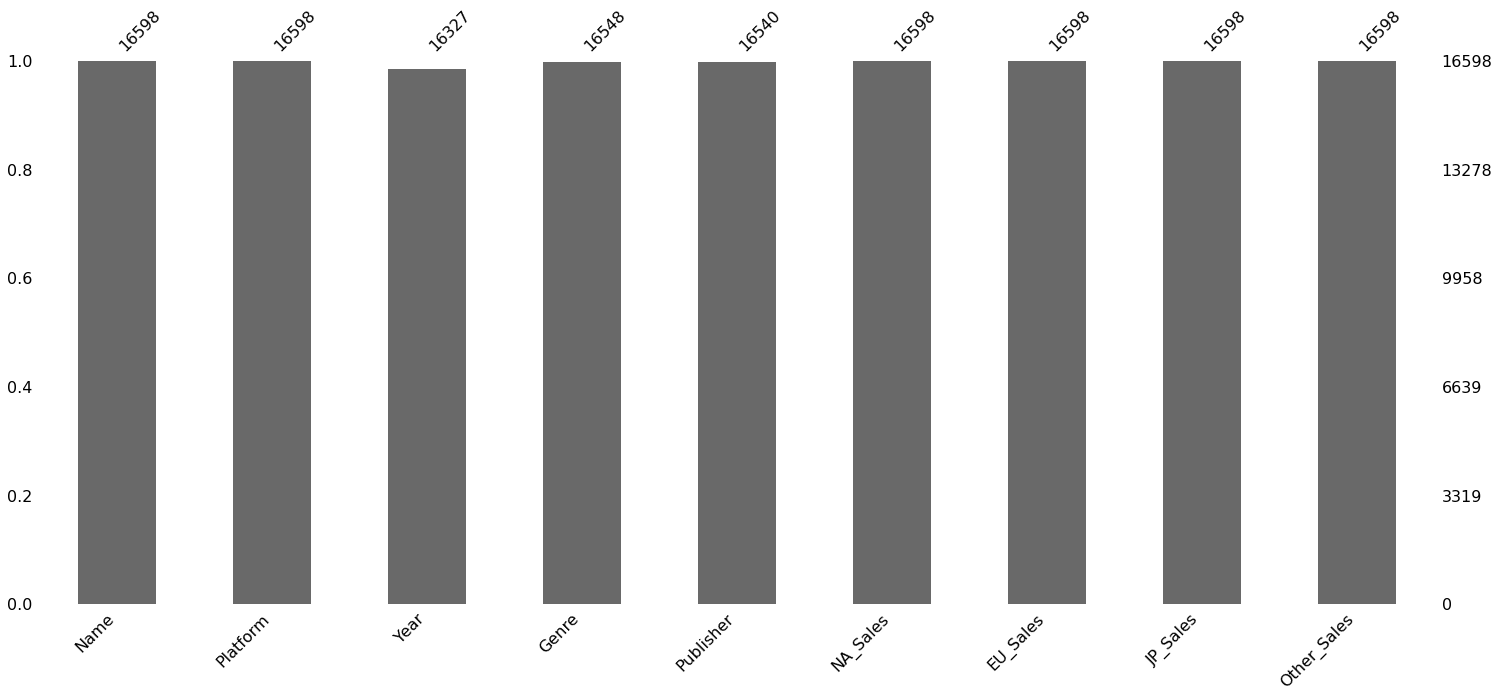

In [3]:
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('vgames2.csv', engine='python')
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)
msno.bar(df) # 결측데이터 시각화 확인
plt.show()

In [4]:
def salesPreprocessing(string) : #Sales 데이터 전처리 함수
  if(string.find('K')>=0) :
    tmp = float(string.replace('K',''))*1000.0
    if(float(tmp)>=100) :
      return float(tmp) / 1000000
    else :
      return float(tmp)
  
  elif(string.find('M')>=0) :
    tmp = float(string.replace('M',''))*1000000
    if(float(tmp)>=100) :
      return float(tmp) / 1000000
    else :
      return float(tmp)

  return float(string)

df['NA_Sales'] = df['NA_Sales'].apply(salesPreprocessing)
df['EU_Sales'] = df['EU_Sales'].apply(salesPreprocessing)
df['JP_Sales'] = df['JP_Sales'].apply(salesPreprocessing)
df['Other_Sales'] = df['Other_Sales'].apply(salesPreprocessing)
df[df['Genre']=='Action']

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
7,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,0.07,0.00,0.11,0.01
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011.0,Action,THQ,0.04,0.03,0.00,0.01
15,Mini Ninjas,PS3,2009.0,Action,Eidos Interactive,0.14,0.16,0.00,0.06
...,...,...,...,...,...,...,...,...,...
16575,Grand Theft Auto V,PC,2015.0,Action,Take-Two Interactive,0.36,0.64,0.00,0.08
16581,LEGO The Hobbit,XOne,2014.0,Action,Warner Bros. Interactive Entertainment,0.13,0.12,0.00,0.02
16583,LEGO Indiana Jones 2: The Adventure Continues,Wii,2009.0,Action,Activision,0.91,0.39,0.00,0.13
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00


In [5]:
def yearPreprocessing(year) : # Year 데이터 전처리 함수 0 -> 2000 NaN -> 0
  if year != year :
    return 0
  elif year < 1000 and year > 20 :
    return year + 1900
  elif year < 1000 and year <= 20 :
    return year + 2000
  return year

df['Genre'] = df['Genre'].fillna('Unknown')
df['Publisher'] = df['Publisher'].fillna('Unknown')
df['Year'] = df['Year'].apply(yearPreprocessing)

In [6]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


데이터 전처리
- Sales의 단위는 M
- year은 0 -> 2000, 20>=year 값은 2000년대, 20<year 값은 1900년대로 설정
- year의 결측값은 위 전처리 후 0으로 변경
- Ganre와 Publisher 결측값은 Unknown으로 변경

# 1. 지역에 따라서 선호하는 게임 장르가 다를까 #

In [7]:
# 지역에 따라 장르마다 판매량 차이가 있는지 확인하기 위해 Anova Test 진행
from scipy import stats

In [8]:
df_NA = pd.crosstab(index = df['NA_Sales'], columns = df['Genre'], values = df['NA_Sales'], aggfunc = 'sum').fillna(0)
df_EU = pd.crosstab(index = df['EU_Sales'], columns = df['Genre'], values = df['EU_Sales'], aggfunc = 'sum').fillna(0)
df_JP = pd.crosstab(index = df['JP_Sales'], columns = df['Genre'], values = df['JP_Sales'], aggfunc = 'sum').fillna(0)
df_Other = pd.crosstab(index = df['Other_Sales'], columns = df['Genre'], values = df['Other_Sales'], aggfunc = 'sum').fillna(0)

In [9]:
def anova_Sales(df_Sales) :
  g1 = df_Sales['Action']
  g2 = df_Sales['Adventure']
  g3 = df_Sales['Fighting']
  g4 = df_Sales['Misc']
  g5 = df_Sales['Platform']
  g6 = df_Sales['Puzzle']
  g7 = df_Sales['Racing']
  g8 = df_Sales['Role-Playing']
  g9 = df_Sales['Shooter']
  g10 = df_Sales['Simulation']
  g11 = df_Sales['Sports']
  g12 = df_Sales['Strategy']
  return stats.f_oneway(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12)

In [10]:
anova_NA = anova_Sales(df_NA)
anova_EU = anova_Sales(df_EU)
anova_JP = anova_Sales(df_JP)
anova_Other = anova_Sales(df_Other)
print('NA_Sales Anova Test :', anova_NA)
print('EU_Sales Anova Test :', anova_EU)
print('JP_Sales Anova Test :', anova_JP)
print('Other_Sales Anova Test :', anova_Other)

NA_Sales Anova Test : F_onewayResult(statistic=49.361723509582205, pvalue=1.6677808724618496e-103)
EU_Sales Anova Test : F_onewayResult(statistic=44.84676305291404, pvalue=2.170311204109483e-92)
JP_Sales Anova Test : F_onewayResult(statistic=46.03423814228897, pvalue=2.5433882509941328e-93)
Other_Sales Anova Test : F_onewayResult(statistic=27.580524369350915, pvalue=5.820577043984507e-54)


pvalue가 0.05보다 작으므로 각 지역마다 장르별 판매량의 차이가 있다

In [66]:
df_NA2 = df.groupby('Genre').agg({'NA_Sales': np.sum}) # 장르별로 시각화하기 위해 장르로 그룹화함
df_NA2 = df_NA2.drop(['Unknown'])
df_EU2 = df.groupby('Genre').agg({'EU_Sales': np.sum})
df_EU2 = df_EU2.drop(['Unknown'])
df_JP2 = df.groupby('Genre').agg({'JP_Sales': np.sum})
df_JP2 = df_JP2.drop(['Unknown'])
df_Other2 = df.groupby('Genre').agg({'Other_Sales': np.sum})
df_Other2 = df_Other2.drop(['Unknown'])
df_NA2

,NA_Sales
Genre,
Action,874.81
Adventure,105.66
Fighting,223.20
Misc,408.05
Platform,446.44
Puzzle,123.35
Racing,357.19
Role-Playing,319.54
Shooter,581.92


## 지역에 따라 장르마다 판매량이 어떻게 다른지 시각화

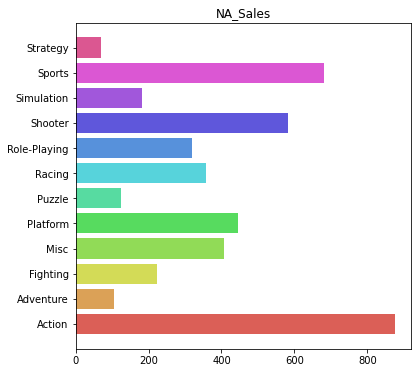

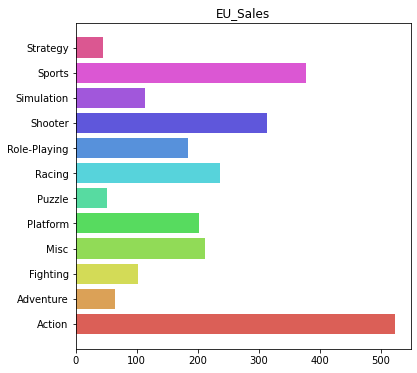

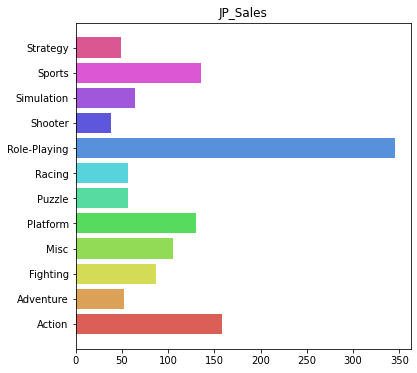

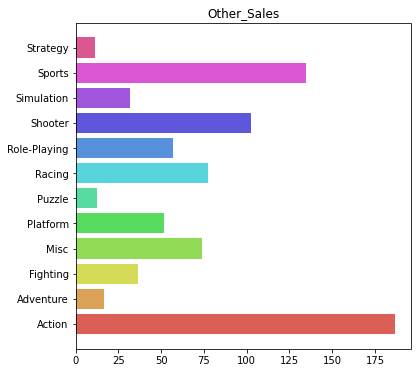

In [67]:
import seaborn as sns

label = ['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports','Strategy']
index = np.arange(len(label))
colors = sns.color_palette('hls',len(label))
plt.figure(figsize=(6,6))
plt.barh(index,df_NA2['NA_Sales'],color=colors)
plt.title('NA_Sales')
plt.yticks(index, label)
plt.show()

plt.figure(figsize=(6,6))
plt.barh(index,df_EU2['EU_Sales'],color=colors)
plt.title('EU_Sales')
plt.yticks(index, label)
plt.show()

plt.figure(figsize=(6,6))
plt.barh(index,df_JP2['JP_Sales'],color=colors)
plt.title('JP_Sales')
plt.yticks(index, label)
plt.show()

plt.figure(figsize=(6,6))
plt.barh(index,df_Other2['Other_Sales'],color=colors)
plt.title('Other_Sales')
plt.yticks(index, label)
plt.show()

## 북미, 유럽, 나머지들은 Action 장르 게임의 판매량이 가장 높다.
## 일본은 RPG 장르 게임의 판매량이 가장 높다.

# 2. 연도별 게임의 트렌드가 있을까? 

## 연도별 장르에 따른 게임 판매량 분석

In [13]:
year_game = df[df['Year']!=0].copy()
year_game['Year'] = pd.to_datetime(year_game['Year'],format='%Y')
year_game['Year'] = year_game['Year'].dt.year
year_game['Total_Sales'] = year_game['EU_Sales']+year_game['NA_Sales']+year_game['JP_Sales']+year_game['Other_Sales']
year_game_cross = pd.crosstab(index = year_game['Year'], columns = year_game['Genre'], values = year_game['Total_Sales'], aggfunc = 'sum').fillna(0)
year_game_cross.drop('Unknown',axis=1, inplace=True)
year_game
bins = list(range(1980, 2025, 5)) # 년도를 5년단위로 끊기
bins_label = [str(x)+"~"+str(x+4) for x in bins]
year_game["level"] = pd.cut(year_game["Year"], bins, right=False, labels=bins_label[:-1])
year_game

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,level
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04,2005~2009
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18,2005~2009
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02,2010~2014
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04,2010~2014
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25,2010~2014
...,...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20,2005~2009
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01,2005~2009
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79,2015~2019
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38,2010~2014


In [14]:
year_game_cross2 = pd.crosstab(index = year_game['level'], columns = year_game['Genre'], values = year_game['Total_Sales'], aggfunc = 'sum').fillna(0)
year_game_cross2.drop('Unknown',axis=1, inplace=True)
year_game_cross2

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
level,,,,,,,,,,,,
1980~1984,26.34,0.40,0.77,7.16,19.57,16.21,8.00,0.00,52.49,0.44,11.21,0.00
1985~1989,24.76,4.38,6.47,1.28,102.69,46.54,4.10,15.25,7.28,0.07,20.57,0.00
1990~1994,20.35,18.29,32.84,8.18,91.46,18.77,18.98,27.36,13.65,8.33,19.06,5.68
1995~1999,118.80,26.51,90.67,55.25,117.41,20.17,129.83,155.41,55.24,43.71,127.41,51.83
2000~2004,321.35,33.74,103.83,102.52,191.49,27.22,203.77,180.39,153.30,65.83,275.09,36.66
2005~2009,531.78,90.03,127.43,383.72,184.64,90.64,234.23,231.81,280.15,199.81,527.72,43.16
2010~2014,581.53,51.05,69.90,216.49,112.62,20.50,114.06,248.08,378.35,64.98,268.16,33.47
2015~2019,88.11,9.82,11.63,12.81,8.13,0.69,9.59,43.22,84.29,6.00,56.12,2.34


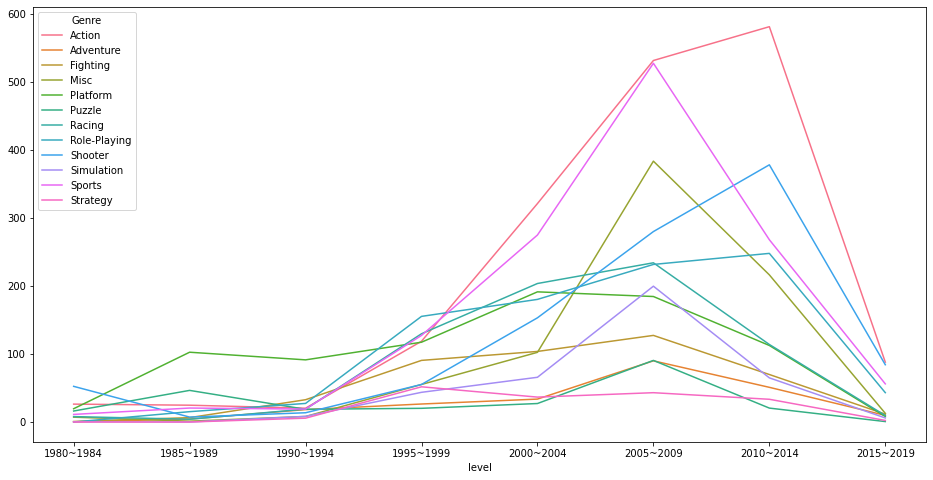

In [15]:
plt.rcParams['figure.figsize'] = [16, 8]
sns.lineplot(data = year_game_cross2,  dashes = False, alpha = 1);

## 연도별 게임 장르 트렌드 분석
- 1980~1984 Shooter 장르가 가장 많이 팔림
- 1985~1994 Platform 장르가 가장 많이 팔림
- 1995~1999 Sports, Action, Racing, Role-Playing 등이 급상승함
- 2000~2009 Action과 Sports 장르가 압도적으로 많이 팔림
- 2010~2014 Action 장르는 많이 팔리나, Sports 장르는 판매량이 확 줄어듬, Shooter 장르의 상승
- 2015~2019 Action과 Shooter가 트렌드라고 볼 수 있다.

# 연도별 플랫폼 트렌드 분석 시각화

In [42]:
platform_game_cross = pd.crosstab(index = year_game['level'], columns = year_game['Platform'], values = year_game['Total_Sales'], aggfunc = 'sum').fillna(0)
platform_game_cross['PS'] = platform_game_cross['PS']+platform_game_cross['PS2']+platform_game_cross['PS3']+platform_game_cross['PS4']
platform_game_cross['PS']
platform_game_cross.drop(['GG','GEN','DC','3DO','SCD','TG16','NG','WS','PCFX','WiiU','PSV','SAT','PS2','PS3','PS4'], axis=1, inplace=True)
platform_game_cross


Platform,2600,3DS,DS,GB,GBA,GC,N64,NES,PC,PS,PSP,SNES,Wii,X360,XB,XOne
level,,,,,,,,,,,,,,,,
1980~1984,82.05,0.00,0.00,0.00,0.00,0.00,0.00,61.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1985~1989,4.43,0.00,0.02,66.40,0.00,0.00,0.00,162.47,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1990~1994,0.00,0.00,0.00,48.13,0.00,0.00,0.00,27.54,15.87,6.03,0.00,150.45,0.00,0.00,0.00,0.00
1995~1999,0.00,0.00,0.00,110.90,0.00,0.00,180.71,0.00,34.09,580.85,0.00,49.59,0.00,0.00,0.00,0.00
2000~2004,0.00,0.00,17.41,29.00,270.34,157.58,37.30,0.00,38.02,947.78,7.09,0.00,0.00,0.00,191.72,0.00
2005~2009,0.00,0.00,670.81,0.00,42.54,39.15,0.00,0.00,46.32,767.45,220.21,0.00,676.95,412.62,59.85,0.00
2010~2014,0.00,212.66,129.41,0.00,0.00,0.00,0.00,0.00,109.24,711.23,64.24,0.00,230.69,542.84,0.00,71.05
2015~2019,0.00,33.52,0.00,0.00,0.00,0.00,0.00,0.00,10.63,175.33,0.12,0.00,1.56,13.85,0.00,70.05


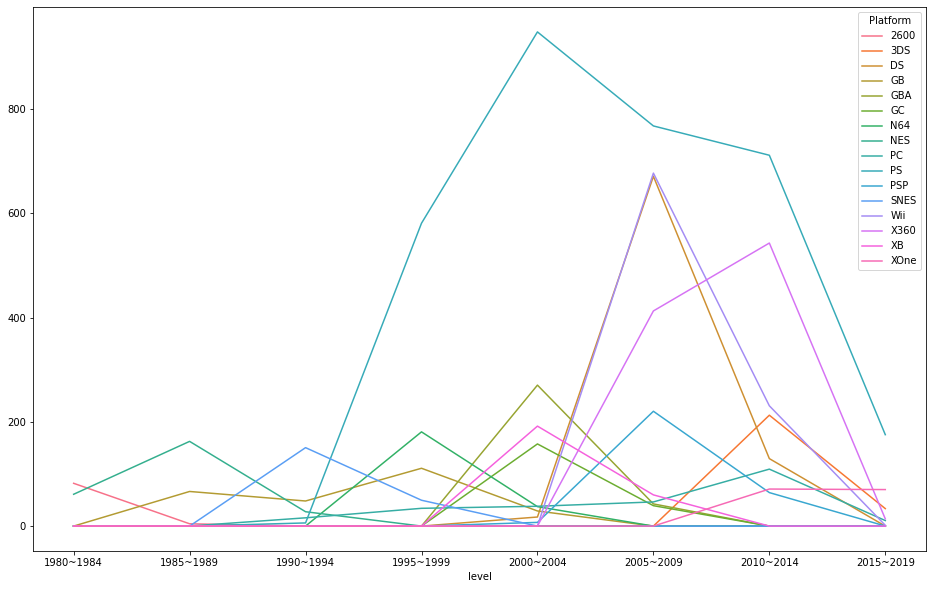

In [43]:
plt.rcParams['figure.figsize'] = [16, 10]
sns.lineplot(data = platform_game_cross,  dashes = False, alpha = 1);

#연도별 플랫폼별 판매량 분석 결과
- 플스 출시 이후부터 압도적으로 판매량이 많다. 즉 플랫폼 트렌드는 PS다.
- PC게임의 판매량이 낮은 이유는 세계적인 문제인 불법 복제의 문제로 인한 것으로 보인다.

#3. 출고량이 높은 게임에 대한 분석

In [18]:
df['Total_Sales'] = df['EU_Sales']+df['NA_Sales']+df['JP_Sales']+df['Other_Sales']
df_rank = df.sort_values(by=['Total_Sales'], axis=0, ascending=False).copy()
df_rank.head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
1203,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16531,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
10488,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


In [19]:
df_rank2 = df_rank[['Name', 'Total_Sales']]
df_rank2 = df_rank2.head(10)
df_rank2

,Name,Total_Sales
2908,Wii Sports,82.74
4199,Super Mario Bros.,40.24
12579,Mario Kart Wii,35.83
3352,Wii Sports Resort,33.00
7829,Pokemon Red/Pokemon Blue,31.38
1203,Tetris,30.26
6937,New Super Mario Bros.,30.01
3014,Wii Play,29.01
16531,New Super Mario Bros. Wii,28.61
10488,Duck Hunt,28.31


# 전체 판매량 상위 10개 게임 시각화 

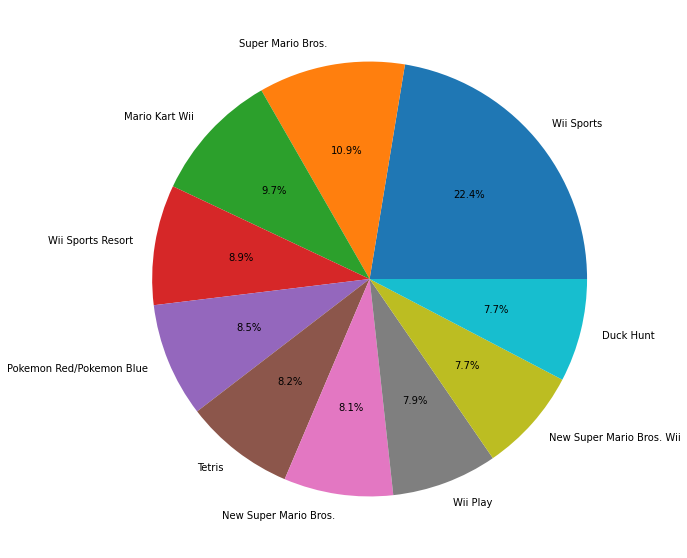

In [20]:
ratio = df_rank2['Total_Sales']
labels = df_rank2['Name']
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

## 상위에 랭크한 10개의 게임 모두 닌텐도 게임이다.
## 또한 상위권게임들 대부분 전작이 유명한 후속작이거나 IP가 유명하다

In [63]:
df_rank_pub = df.groupby('Platform').agg({'Total_Sales': np.sum})
df_rank_pub = df_rank_pub.sort_values(by=['Total_Sales'], axis=0, ascending=False)
df_rank_pub.reset_index(inplace=True)
df_rank_pub = df_rank_pub.head(10)
df_rank_pub

,Platform,Total_Sales
0,PS2,1255.77
1,X360,979.60
2,PS3,957.89
3,Wii,926.05
4,DS,821.46
5,PS,730.84
6,GBA,317.85
7,PSP,296.22
8,PS4,278.16
9,PC,257.99


### Platform을 기준으로 판매량 비율

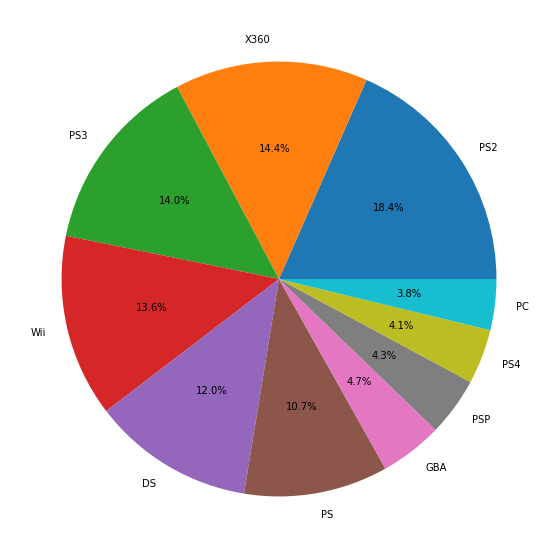

In [64]:
ratio = df_rank_pub['Total_Sales']
labels = df_rank_pub['Platform']
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [61]:
df_10year = df[df['Year']>=2011] # 10년 이내 게임들만 추출
df_10year = df_10year.sort_values(by=['Total_Sales'], axis=0, ascending=False)
df_10year.head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3483,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2809,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
1971,Pokemon X/Pokemon Y,3DS,2013.0,Unknown,Nintendo,5.17,4.05,4.34,0.79,14.35
9070,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012.0,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012.0,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
14120,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
11123,Mario Kart 7,3DS,2011.0,Racing,Nintendo,4.74,3.91,2.67,0.89,12.21
2008,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99


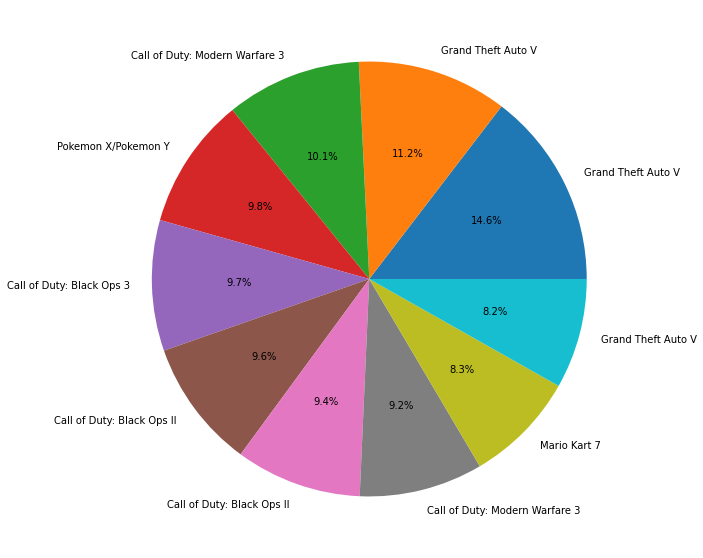

In [26]:
df_10year = df_10year.head(10)
ratio = df_10year['Total_Sales']
labels = df_10year['Name']
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

# 10년 이내 게임들 플랫폼 점유율

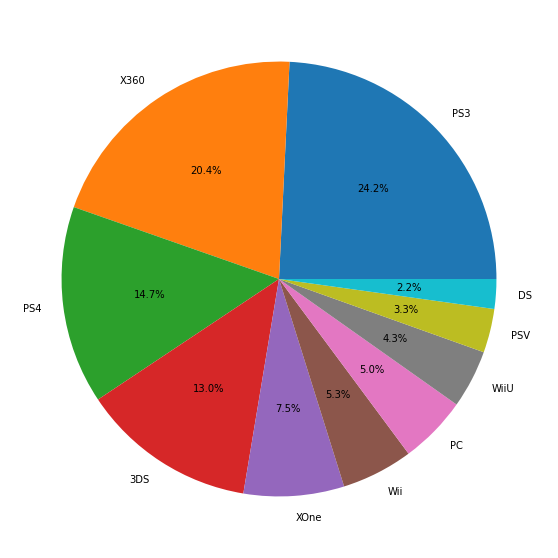

In [65]:
df_10year_pub = df[df['Year']>=2011]
df_10year_pub = df_10year_pub.groupby('Platform').agg({'Total_Sales': np.sum})
df_10year_pub.reset_index(inplace=True)
df_10year_pub = df_10year_pub.sort_values(by=['Total_Sales'], axis=0, ascending=False)
df_10year_pub = df_10year_pub.head(10)
ratio = df_10year_pub['Total_Sales']
labels = df_10year_pub['Platform']
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

## 상위권 게임들 대부분 높은 점유율을 가지고 있는 플랫폼에 몰려있음
## 사용자가 많은 플랫폼을 골라야 게임의 노출 및 접근성이 좋아짐.
## 잘나가던 플랫폼의 비중이 더 커짐

- 상위권 게임들은 IP가 유명하거나, 전작이 유명하거나, 너무 재밌어서 대박을 치거나 둘 중 하나이다.
- 유명한 IP를 활용하지 않거나 후속작이 아닌 경우 성공하기는 쉽지않다.
- 플랫폼은 사용자가 많은 곳으로 가야 기존에 다른 게임을 하던 사람들에게도 노출이 되고, 접근성이 좋아진다.